In [1]:
!pip install tensorflowjs
!pip install tensorflow-datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.5 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalle

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflowjs as tfjs
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np



In [3]:
# Load the Food 101 dataset
# !!! takes about 15 min depending on your download speed
dataset_name = "food101"
(ds_train, ds_test), ds_info = tfds.load(
    name=dataset_name,
    split=["train", "validation"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# Display dataset information
print(ds_info)

# Example: Display the first 5 classes
for i, label in enumerate(ds_info.features["label"].names[:5]):
    print(f"Class {i+1}: {label}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteH9UL82/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteH9UL82/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_dir=PosixGPath('/tmp/tmpj56q2glhtfds'),
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    

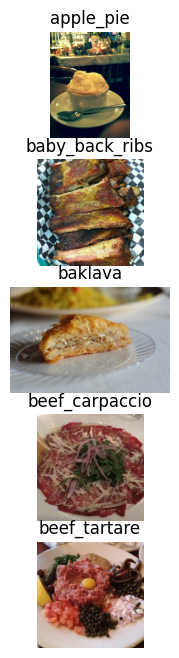

In [4]:
# Function to display images from different classes
def display_images(dataset, num_classes=5, num_images_per_class=1):
    class_names = ds_info.features['label'].names
    plt.figure(figsize=(15, 8))

    for i in range(num_classes):
        class_ds = dataset.filter(lambda img, label: label == i)
        class_samples = class_ds.take(num_images_per_class)

        for j, (img, label) in enumerate(class_samples):
            plt.subplot(num_classes, num_images_per_class, i * num_images_per_class + j + 1)
            plt.imshow(img.numpy())
            plt.title(class_names[i])
            plt.axis('off')

# Display images
display_images(ds_train, num_classes=5, num_images_per_class=1)
plt.show()

In [5]:
# Preprocess data and define the model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(101, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


17225924/17225924 [==============================] - 0s 0us/step


In [6]:
# Take only 1/10 of the training dataset
ds_train = ds_train.take(ds_info.splits['train'].num_examples // 10)
ds_test = ds_test.take(ds_info.splits['validation'].num_examples // 10)

In [7]:
# Define preprocessing function
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet.preprocess_input(image)
    label = tf.one_hot(label, 101)
    return image, label

# Apply preprocessing to the datasets
ds_train = ds_train.map(preprocess_image)
ds_test = ds_test.map(preprocess_image)

# Batch and prefetch the datasets
batch_size = 32
ds_train = ds_train.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [8]:
ds_test

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [9]:
# Train the model
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)


# Modify the model.fit function
history = model.fit(
    ds_train,
    epochs=10,  # You can set a maximum number of epochs
    validation_data=ds_test,
    callbacks=[early_stopping]  # Add the early stopping callback
)

Epoch 1/10
237/237 [==============================] - 372s 2s/step - loss: 3.1833 - accuracy: 0.2669 - val_loss: 2.2374 - val_accuracy: 0.4194
Epoch 2/10
237/237 [==============================] - 318s 1s/step - loss: 2.0810 - accuracy: 0.4816 - val_loss: 1.9548 - val_accuracy: 0.4947
Epoch 3/10
237/237 [==============================] - 328s 1s/step - loss: 1.8215 - accuracy: 0.5360 - val_loss: 1.9522 - val_accuracy: 0.4986
Epoch 4/10
237/237 [==============================] - 336s 1s/step - loss: 1.5486 - accuracy: 0.5975 - val_loss: 1.8314 - val_accuracy: 0.5208
Epoch 5/10
237/237 [==============================] - 344s 1s/step - loss: 1.4094 - accuracy: 0.6316 - val_loss: 1.8015 - val_accuracy: 0.5343
Epoch 6/10
237/237 [==============================] - 397s 2s/step - loss: 1.0894 - accuracy: 0.7155 - val_loss: 1.8415 - val_accuracy: 0.5410
Epoch 7/10
237/237 [==============================] - 341s 1s/step - loss: 1.1021 - accuracy: 0.7100 - val_loss: 1.8483 - val_accuracy: 0.5370

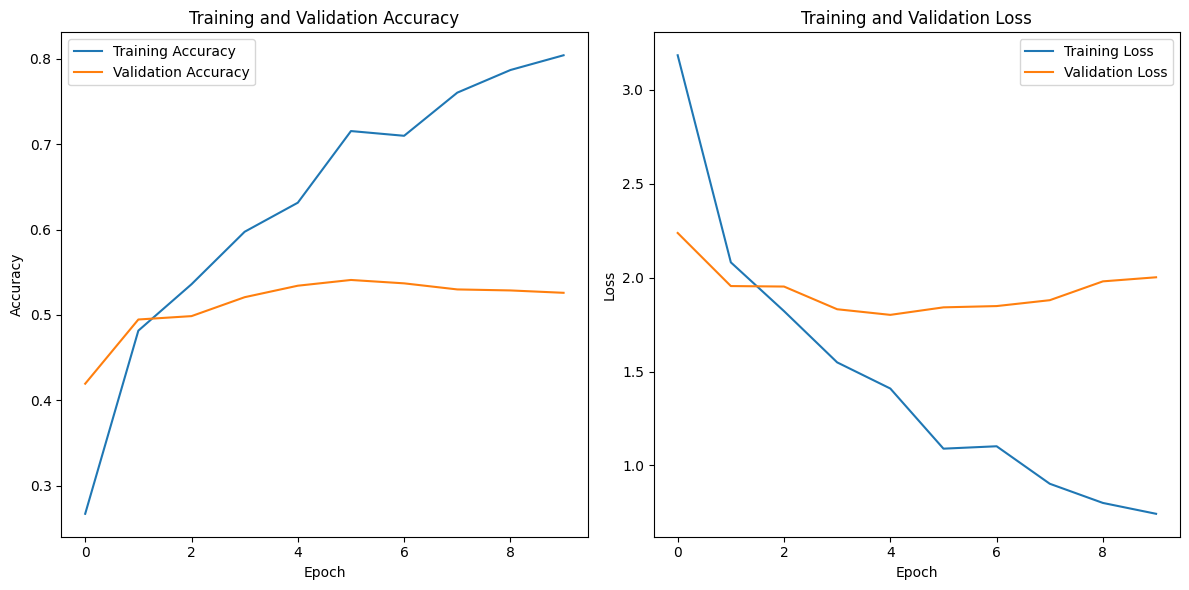

In [10]:
# Assuming 'history' is the object returned by model.fit()

# Plot training and validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(validation_generator)
print(f'Test Accuracy: {test_acc}')

# Make predictions on the test set
predictions = model.predict(validation_generator)

# Get true labels
true_labels = np.argmax(validation_generator.labels, axis=1)

# Get predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# Plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [11]:
tfjs_target_dir = '/content'
tfjs.converters.save_keras_model(model, tfjs_target_dir)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
# Save the entire model as a `.keras` zip archive.
model.save('food_js.keras')
